<a href="https://colab.research.google.com/github/Prathyusha-Akundi/Soil-Classification/blob/main/soil_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [2]:

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from warnings import filterwarnings
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model


filterwarnings('ignore')
np.random.seed(101)


In [3]:
root_dir = '/content/drive/MyDrive/Upwork/Soil Classification/'
IMAGE_DIR = root_dir+'Datasets/preprocessed_irsid/'

In [4]:
preprocessed_df = pd.read_csv(root_dir+'Datasets/preprocessed_irsid.csv')
preprocessed_df['PatchName'] = preprocessed_df.PatchName.apply(lambda x: x+'.png')

In [5]:
preprocessed_df.head()

,PatchName,filename,Type
0,Sample4_patch_32.png,Sample4,Clay
1,Sample4_patch_33.png,Sample4,Clay
2,Sample4_patch_34.png,Sample4,Clay
3,Sample14_patch_48.png,Sample14,Sandy Loam
4,Sample12_patch_46.png,Sample12,Sand


In [6]:
train_val, test_df = train_test_split(preprocessed_df, test_size=0.1,random_state=10,stratify=preprocessed_df.Type.values)
train_df, val_df = train_test_split(train_val, test_size=0.1,random_state=10,stratify=train_val.Type.values)

In [7]:
def get_generator(df=train_df, image_dir=IMAGE_DIR, x_col='PatchName', y_cols='Type', shuffle=True, batch_size=4, seed=42, target_w = 256, target_h = 256):
    
    
    print("getting  generator...") 
    # normalize images
    image_generator1 = ImageDataGenerator(
        rescale=1./255,  
        # featurewise_center = True,
        # featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        # rotation_range = 15,

        samplewise_center=True,
        samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator1 = image_generator1.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="categorical",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator1

In [27]:
batch_size = 16
train_generator = get_generator(df = train_df, batch_size = batch_size)
valid_generator = get_generator(df = val_df, batch_size = batch_size, shuffle=False)
test_generator = get_generator(df = test_df, batch_size = batch_size, shuffle=False)

getting  generator...
Found 502 validated image filenames belonging to 4 classes.
getting  generator...
Found 56 validated image filenames belonging to 4 classes.
getting  generator...
Found 62 validated image filenames belonging to 4 classes.


In [9]:
class_labels = train_df['Type'].values
class_labels.shape

(502,)

In [10]:
x,y = next(train_generator)

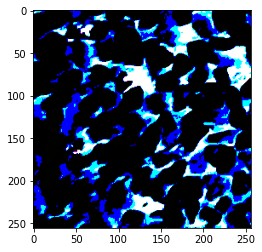

In [11]:
i = 1
plt.imshow(np.uint8(x[i]))


In [12]:
y[i]

array([0., 0., 1., 0.], dtype=float32)

In [13]:
train_generator.class_indices

{'Clay': 0, 'Loam': 1, 'Sand': 2, 'Sandy Loam': 3}

In [14]:
valid_generator.class_indices

{'Clay': 0, 'Loam': 1, 'Sand': 2, 'Sandy Loam': 3}

In [15]:
test_generator.class_indices

{'Clay': 0, 'Loam': 1, 'Sand': 2, 'Sandy Loam': 3}

In [16]:
def get_classifier_model(labels,dim = 256):
    ### Base Model ###
    # Input
    
    input1 = Input(shape = (dim, dim, 3))
    
    # Base EfficientNet pretrained model
    base = DenseNet121(
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        # pooling = 'avg'
    )
    x = base(input1)    
    # x = Conv2D(512, (3, 3), padding='same',name='densenet_features', activation = "relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # x = Dense(128, activation = "relu")(x1)
   
  
    ### Rebuild top ###
    x = Dense(labels, activation = "sigmoid")(x)


    model = Model(inputs = input1, outputs = x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
   
    return model

In [17]:
model = get_classifier_model(len(train_generator.class_indices))

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)
checkpoint_filepath = root_dir+'models/densenet121_v2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [20]:
STEP_SIZE_TRAIN=len(train_df)//batch_size
STEP_SIZE_VALID= len(val_df)//batch_size
STEP_SIZE_TEST=len(test_df)//batch_size
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,verbose=1, 
                        validation_steps=STEP_SIZE_VALID, epochs=25, callbacks=[callback, model_checkpoint_callback])

Epoch 1/25
31/31 [==============================] - ETA: 0s - loss: 0.4882 - categorical_accuracy: 0.8436
Epoch 00001: val_categorical_accuracy improved from -inf to 0.64583, saving model to /content/drive/MyDrive/Upwork/Soil Classification/models/densenet121_v2
31/31 [==============================] - 29s 307ms/step - loss: 0.4882 - categorical_accuracy: 0.8436 - val_loss: 2.0831 - val_categorical_accuracy: 0.6458
Epoch 2/25
31/31 [==============================] - ETA: 0s - loss: 0.3151 - categorical_accuracy: 0.9074
Epoch 00002: val_categorical_accuracy improved from 0.64583 to 0.68750, saving model to /content/drive/MyDrive/Upwork/Soil Classification/models/densenet121_v2
31/31 [==============================] - 7s 216ms/step - loss: 0.3151 - categorical_accuracy: 0.9074 - val_loss: 4.0280 - val_categorical_accuracy: 0.6875
Epoch 3/25
31/31 [==============================] - ETA: 0s - loss: 0.1338 - categorical_accuracy: 0.9465
Epoch 00003: val_categorical_accuracy improved from 0.

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
loss, val_acc = model.evaluate(valid_generator)
print(val_acc)

4/4 [==============================] - 1s 222ms/step - loss: 0.0381 - categorical_accuracy: 0.9821
0.9821428656578064


In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print(test_acc)

4/4 [==============================] - 1s 162ms/step - loss: 0.2117 - categorical_accuracy: 0.9516
0.9516128897666931
